## 深度学习解决NLP监督任务

![jupyter](./imgs/dl_for_nlp.png)

In [1]:
import re

import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

random_seed = 100

import warnings

warnings.filterwarnings('ignore')

## 1. 数据预处理与数据集划分

In [2]:
def preprocess_text(words):
    # 转为小写
    words = words.lower()
    # 去除标点，保留中英文字符
    words = re.sub('[^a-z^0-9^\u4e00-\u9fa5]', '', words)
    # 将所有数字都转为0
    words = re.sub('[0-9]', '0', words)
    words = ' '.join(words)
    # 合并连续的空格
    words = re.sub('\s{2,}', ' ', words)
    return words.strip()

In [3]:
raw_train_df = pd.read_csv('./processed_data/train.csv')
raw_train_df['text'] = raw_train_df['text'].apply(preprocess_text)
raw_train_df = raw_train_df[raw_train_df['text'] != '']
# 过滤掉处理后文本为空的数据
raw_train_df[['text', 'label']].head()

,text,label
0,肺 炎 疫 情,1
1,西 方 记 者 挑 事 提 问 w h o 总 干 事 用 事 实 力 挺 中 国 0 0 ...,1
2,人 数 终 于 始 呈 下 降 趋 势 这 个 春 节 有 喜 有 忧 但 事 情 终 有 ...,1
3,抗 病 毒 小 刘 上 线 今 天 有 好 几 个 朋 友 来 问 我 戴 没 戴 口 罩 ...,1
4,潜 伏 期 传 染 后 期 会 不 会 更 惊 讶 o 最 新 疫 情 地 图 出 炉 这 ...,1


In [4]:
test_df = pd.read_csv('./processed_data/test.csv')
test_df['text'] = test_df['text'].apply(preprocess_text)
test_df = test_df[test_df['text'] != '']  # 过滤掉处理后文本为空的数据
test_df[['text', 'label']].head()

,text,label
0,星 火 线 上 课 足 不 出 户 同 样 进 步 l 星 火 教 育 呼 市 的 视 频,2
1,中 科 院 病 毒 研 究 所 石 正 丽 老 师 演 讲 追 踪 s a r s 的 源 ...,2
2,嗯 熊 中 默 就 是 那 个 给 那 位 挂 基 层 辅 警 照 片 暴 平 安 天 门 ...,0
3,今 天 看 到 两 条 让 我 真 的 笑 笑 出 声 的 为 防 病 毒 出 门 抢 购 ...,0
4,莫 西 干,1


In [5]:
# 划分训练集与验证集
train_df, val_df = train_test_split(
    raw_train_df,
    test_size=5000,
    random_state=1234
)
len(train_df), len(val_df)

(74792, 5000)

In [6]:
# 保存划分好的数据集

train_df.to_csv('./dataset/train.csv', index=False)
val_df.to_csv('./dataset/val.csv', index=False)
test_df.to_csv('./dataset/test.csv', index=False)

## 2. 构建TF数据集   

TensorFlow全新的数据读取方式：Dataset API入门教程：https://zhuanlan.zhihu.com/p/30751039

In [7]:
# 读取原始数据集
train_text, train_label = train_df['text'], train_df['label']
val_text, val_label = val_df['text'], val_df['label']
test_text, test_label = test_df['text'], test_df['label']
len(train_label), len(val_label), len(test_label)

(74792, 5000, 9998)

### Tokenizer
Tokenizer是一个分词器，用于文本预处理，序列化，向量化等。  
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer  ｜  
默认情况下，将删除所有标点符号，从而将文本转换为以空格分隔的单词序列（单词可能包含’字符，如I’am）,然后将这些序列分为标记列表，并将它们编入索引或向量化。注意0是保留索引，不会分配给任何单词。

In [1]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    # 根据单词频率排序，保留前num_words个单词，即仅保留最常见的num_words-1个单词
    num_words=None,
    # 一个用于过滤的正则表达式的字符串，这个过滤器作用在每个元素上，默认过滤除‘`’字符外的所有标点符号，制表符和换行符
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    # 标记是否将文本转换为小写
    lower=True,
    # 分词分隔符，前面已经处理成用空格分割了
    split=' ',
    # 是否进行字符级别的分词, 前面已经分好了
    char_level=False,
    # 指定out of vocabulary词, 将被添加到word_index中，
    # 并用于在text_to_sequence调用期间替换词汇外的单词，即用来补充原文本中没有的词。
    oov_token=None
)

# 用训练数据的文本训练tokenizer
tokenizer.fit_on_texts(train_text)

SyntaxError: invalid syntax (482620102.py, line 16)

In [9]:
text = '写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。'
# 将文本数据转化为对应的id序列
tokens = tokenizer.texts_to_sequences(text)
print(tokens)

[[715], [11], [51], [1300], [878], [600], [512], [102], [266], [30], [2], [120], [584], [20], [], [8], [35], [995], [171], [62], [9], [1102], [216], [221], [16], [1213], [1077], [18], [], [1], [], [1], [51], [2], [120], [3], [20], []]


In [10]:
# 保存tokenzier用于预测
tokenizer_save_path = './model/tokenizer.pkl'
joblib.dump(tokenizer, tokenizer_save_path)

['./model/tokenizer.pkl']

### tf dataset
官方API： https://www.tensorflow.org/api_docs/python/tf/data/Dataset
其他：https://www.huaweicloud.com/articles/5fcbf05e61828f8e6eeced07ccedc3c6.html

- from_tensor_slices: 用于创建dataset,其元素是给定张量的切片的元素。
- shuffle: 随机打乱此数据集的样本。从data数据集中按顺序抽取buffer_size个样本放在buffer中，然后打乱buffer中的样本。
buffer中样本个数不足buffer_size，继续从data数据集中安顺序填充至buffer_size，此时会再次打乱。
对于完美的打乱，缓冲区大小需要大于或等于数据集的大小。
- batch: 将数据集的样本构造成批数据。
- prefetch: 创建一个从该数据集中预先读取元素的数据集。大多数数据集输入管道应该以调用预取结束。这允许在处理当前元素时准备后面的元素。这通常会提高延迟和吞吐量，但代价是使用额外的内存来存储预取元素。

pad_sequences是做补齐序列作用的

In [11]:
# 类别数量
NUM_LABEL = 3
# 构造数据集的bacth
BATCH_SIZE = 64
# 最长序列长度，经前面分析，这里取240
MAX_LEN = 240
# bacth读取数据的缓存大小
BUFFER_SIZE = tf.constant(len(train_text), dtype=tf.int64)


def build_tf_dataset(words, label, is_train=False):
    # 将前面的tokenzier用于当前文本进行id序列化
    sequence = tokenizer.texts_to_sequences(words)
    # 把所有序列补齐到最长序列长度，padding方式为在后面补齐
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=MAX_LEN)
    # 将标签转化为tf的one-hot标签，即 1 -> [0, 1, 0]
    label_tensor = tf.convert_to_tensor(
        tf.one_hot(label, NUM_LABEL),
        dtype=tf.float32
    )
    # 将序列化的文本数据与标签在一起制作tf dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (padded_sequence, label_tensor)
    )
    # 训练阶段
    if is_train:
        # 训练阶段将数据打乱
        dataset = dataset.shuffle(BUFFER_SIZE)
        # 按照batch_size构造数据集，去掉不能组成batch的多余数据
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        # 训练时预先将所有的训练数据加载到内存中
        dataset = dataset.prefetch(BUFFER_SIZE)
    else:
        # 非训练阶段无需打乱数据
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
        # 预读取一个Batch内容
        dataset = dataset.prefetch(BATCH_SIZE)
    return dataset


# 分别构造训练、验证、测试tf数据集
train_dataset = build_tf_dataset(train_text, train_label, is_train=True)
val_dataset = build_tf_dataset(val_text, val_label, is_train=False)
test_dataset = build_tf_dataset(test_text, test_label, is_train=False)

In [12]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [[ 821  383  204  146   82  570   18    3  287   20  541  487  727   82
   256  219   20   46   40   87    5  256   19   82  487  727   82  256
   325  325    5    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0

## 3. 模型构建与训练
### 3. 1加载预训练词向量

In [13]:
# 词典大小，留一个unk字符
VOCAB_SIZE = len(tokenizer.index_word) + 1
# 词向量大小
EMBEDDING_DIM = 100

In [3]:
from gensim.models.keyedvectors import KeyedVectors


def get_embeddings(pretrain_vec_path):
    # 加载训练好的词向量为KeyedVectors
    word_vectors = KeyedVectors.load_word2vec_format(
        pretrain_vec_path, binary=False
    )
    # 取出预训练词向量的词汇表
    word_vocab = set(word_vectors.key_to_index.keys())
    # 随机初始化tokenzier词表大小的向量
    token_embeddings = np.random.uniform(
        -0.2,
        0.2,
        size=(VOCAB_SIZE, EMBEDDING_DIM)
    )
    # 从1开始，0是tokenzier预留的索引
    for i in range(1, VOCAB_SIZE):
        # 取出tokenzier索引对应的词
        word = tokenizer.index_word[i]
        # 如果词出现在预训练的词中
        if word in word_vocab:
            # 就将预训练的词向量赋值给它，替换随机初始化
            token_embeddings[i, :] = word_vectors.get_vector(word)
    return token_embeddings


pretrained_vec_path = "./word2vec/sg_ns_100.txt"
# 加载预训练词向量
embeddings = get_embeddings(pretrained_vec_path)
embeddings[:2]

NameError: name 'np' is not defined

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython_darwin_38_64.pyx", line 996, in _pydevd_bundle.pydevd_cython_darwin_38_64.PyDBFrame.trace_dispatch
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_plugin.py", line 116, in cmd_step_into
    if _is_inside_jupyter_cell(frame, pydb) and not filename.endswith("iostream.py"):
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_plugin.py", line 209, in _is_inside_jupyter_cell
    if is_cell_filename(filename):
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_plugin.py", line 220, in is_cell_filename
    ipython_shell = get_ipython()
NameError: name 'get_ipython' is not defined


### 3.2 模型定义

![jupyter](./imgs/textcnn.png)

In [15]:
# 3种卷积核的filter size
FILTERS = [2, 3, 5]
# 卷积核的大小
NUM_FILTERS = 128
# 全连接层大小
DENSE_DIM = 256
# 类别数
CLASS_NUM = 3
# dropout比例
DROPOUT_RATE = 0.5

In [16]:
# 定义一个TextCNN的TF Keras model

def build_text_cnn_model():
    # 模型输入
    inputs = tf.keras.Input(shape=(None,), name='input_data')
    # embedding层定义
    embed = tf.keras.layers.Embedding(
        # 词表大小
        input_dim=VOCAB_SIZE,
        # 词向量维度
        output_dim=EMBEDDING_DIM,
        # # 加载预训练的词向量
        # embeddings_initializer=tf.keras.initializers.Constant(embeddings),
        # 词向量是否训练
        trainable=True,
        # 标记是否用0进行mask标记序列补齐到固定长度
        mask_zero=True
    )(inputs)
    # 在embedding层后接dropout
    embed = tf.keras.layers.Dropout(DROPOUT_RATE)(embed)

    pool_outputs = []
    # 分别对文本进行应用不同filter size的卷积
    for filter_size in FILTERS:
        conv = tf.keras.layers.Conv1D(
            # 卷积核大小
            filters=NUM_FILTERS,
            # filter size
            kernel_size=filter_size,
            # same padding
            padding='same',
            # 激活函数
            activation='relu',
            # 数据格式，最后一维是通道
            data_format='channels_last',
            # 标记是否使用bias
            use_bias=True
        )(embed)
        # 卷积后进行max pooling
        max_pool = tf.keras.layers.GlobalMaxPooling1D(
            data_format='channels_last'
        )(conv)
        # 将对应filter size大小卷积池化后的结果存到list
        pool_outputs.append(max_pool)

    # 将不同filter size卷积池化后的结果进行拼接
    outputs = tf.keras.layers.concatenate(pool_outputs, axis=-1)
    # dense层
    outputs = tf.keras.layers.Dense(DENSE_DIM, activation='relu')(outputs)
    # 对全连接层进行dropout
    outputs = tf.keras.layers.Dropout(DROPOUT_RATE)(outputs)
    # 最终的分类层
    outputs = tf.keras.layers.Dense(CLASS_NUM, activation='softmax')(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


text_cnn_model = build_text_cnn_model()
text_cnn_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    630800      input_data[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 100)    0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 128)    25728       dropout[0][0]                    
_______________________________________________________________________________________

### 3.3 模型训练

In [17]:
# 学习率
LR = 3e-4
# 迭代次数
EPOCHS = 10
# 早停等待次数
EARLY_STOP_PATIENCE = 5

# 定义Loss为分类的交叉熵损失函数
loss_fn = tf.keras.losses.CategoricalCrossentropy()
# 定义优化器为Adam优化器
optimizer = tf.keras.optimizers.Adam(LR)

# 编译模型
text_cnn_model.compile(
    loss=loss_fn,
    optimizer=optimizer,
    # 使用accuracy进行评价
    metrics=['accuracy']
)

# 添加一个早停的callback,可减少模型过拟合
callback = tf.keras.callbacks.EarlyStopping(
    # 通过验证集的accuracy做监控指标，几个epoch该指标不再上升，则早停
    monitor='val_accuracy',
    # 标记几个epoch该指标不再上升，则早停
    patience=EARLY_STOP_PATIENCE,
    # 标记是否还原在监控指标中取得最好结果的模型权重
    restore_best_weights=True
)

# 样本分布不均衡的解决：通过对不同标签的损失进行加权
# 这里标签1的数据最多，降低其权重
class_weight = {0: 0.4, 1: 0.2, 2: 0.4}

# 模型训练
history = text_cnn_model.fit(
    # 输入训练数据集
    train_dataset,
    # 迭代次数
    epochs=EPOCHS,
    # 回调函数
    callbacks=[callback],
    # 指定验证集
    validation_data=val_dataset,
    # 对不同类别进行加权
    class_weight=class_weight
)

Epoch 1/10
1168/1168 [==============================] - 16s 14ms/step - loss: 0.2464 - accuracy: 0.6117 - val_loss: 0.7698 - val_accuracy: 0.6438
Epoch 2/10
1168/1168 [==============================] - 16s 13ms/step - loss: 0.2038 - accuracy: 0.6769 - val_loss: 0.7227 - val_accuracy: 0.6612
Epoch 3/10
1168/1168 [==============================] - 16s 13ms/step - loss: 0.1942 - accuracy: 0.6896 - val_loss: 0.7181 - val_accuracy: 0.6602
Epoch 4/10
1168/1168 [==============================] - 16s 13ms/step - loss: 0.1885 - accuracy: 0.6973 - val_loss: 0.7432 - val_accuracy: 0.6488
Epoch 5/10
1168/1168 [==============================] - 16s 13ms/step - loss: 0.1837 - accuracy: 0.7070 - val_loss: 0.7318 - val_accuracy: 0.6556
Epoch 6/10
1168/1168 [==============================] - 16s 13ms/step - loss: 0.1795 - accuracy: 0.7133 - val_loss: 0.7394 - val_accuracy: 0.6496
Epoch 7/10
1168/1168 [==============================] - 16s 13ms/step - loss: 0.1750 - accuracy: 0.7202 - val_loss: 0.7240 -

In [18]:
# 在测试集上进行评估
test_loss, test_acc = text_cnn_model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 [==============================] - 1s 4ms/step - loss: 0.7176 - accuracy: 0.6693
Test Loss: 0.7176308035850525
Test Accuracy: 0.6693338751792908


In [19]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

(0.0, 0.7995056927204132)

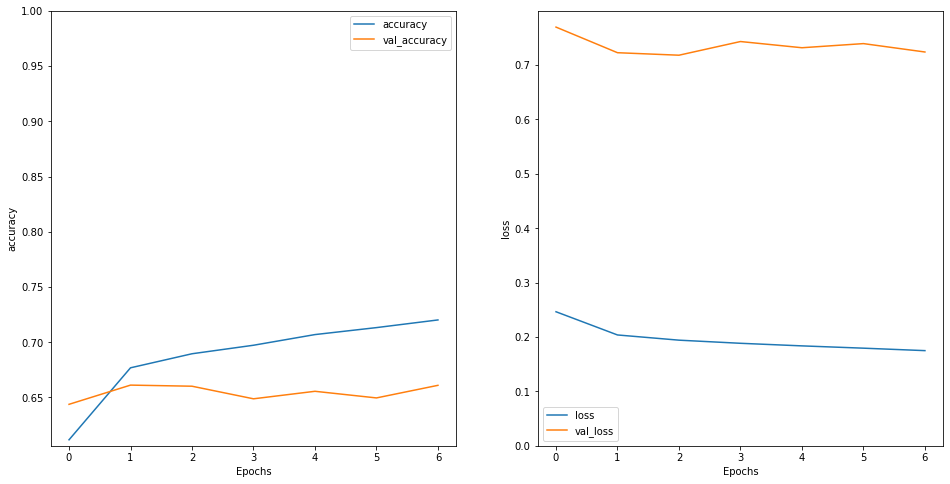

In [20]:
# 将训练过程进行可视化

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
# 保存训练好的模型
model_save_path = './model/text_cnn'

text_cnn_model.save(model_save_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/text_cnn/assets


### 3.4 模型评估

In [22]:
# 对测试集进行预测，得到每个测试样本的在各个标签的分数
predictions = text_cnn_model.predict(test_dataset)
predictions[:10]

array([[0.13284105, 0.68675524, 0.18040365],
       [0.17581712, 0.4248113 , 0.3993716 ],
       [0.1540485 , 0.54412735, 0.30182415],
       [0.3499045 , 0.31558296, 0.33451253],
       [0.38513228, 0.42451873, 0.19034901],
       [0.5639943 , 0.3865751 , 0.04943058],
       [0.03249473, 0.230097  , 0.73740834],
       [0.6131127 , 0.2869413 , 0.09994598],
       [0.58062726, 0.273777  , 0.14559576],
       [0.11190969, 0.26352182, 0.62456846]], dtype=float32)

In [23]:
# 取出每个测试样本分数最大的标签作为预测标签
preds = np.argmax(predictions, axis=-1)
preds[:10]

array([1, 1, 1, 0, 1, 0, 2, 0, 0, 2])

In [24]:
from sklearn.metrics import classification_report

# 查看分类结果
result = classification_report(test_label, preds)
print(result)

              precision    recall  f1-score   support

           0       0.48      0.78      0.60      1796
           1       0.83      0.60      0.70      5651
           2       0.63      0.74      0.68      2551

    accuracy                           0.67      9998
   macro avg       0.65      0.71      0.66      9998
weighted avg       0.72      0.67      0.68      9998



## 4. 模型预测

训练好的模型如何进行在线预测
1. 加载保存好的模型
2. 对预测文本进行预处理、tokenizer以及padding
3. 输入模型进行预测
4. 展示预测结果

In [25]:
# 加载训练好的Tokenzier
tokenizer_save_path = './model/tokenizer.pkl'
tokenizer = joblib.load(tokenizer_save_path)

# 加载TextCNN模型
model_save_path = './model/text_cnn'
text_cnn_model = tf.keras.models.load_model(model_save_path)
text_cnn_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    630800      input_data[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 100)    0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 128)    25728       dropout[0][0]                    
_______________________________________________________________________________________

In [26]:
predict_sentences = [
    "因为疫情被困家里2个月了，好压抑啊，感觉自己抑郁了！",
    "我国又一个新冠病毒疫苗获批紧急使用。",
    "我们在一起，打赢这场仗，抗击新馆疫情，我们在行动！"]

# 预处理文本
predict_texts = [preprocess_text(text) for text in predict_sentences]
# 进行tokenizer
predict_sequences = tokenizer.texts_to_sequences(predict_texts)
# 进行padding
sequence_padded = pad_sequences(
    predict_sequences,
    padding='post',
    maxlen=MAX_LEN
)
# 得到预测的Logits
predict_logits = text_cnn_model.predict(sequence_padded)
predict_logits

array([[0.7622092 , 0.15547498, 0.08231588],
       [0.15637168, 0.45522764, 0.3884007 ],
       [0.02579996, 0.17541012, 0.7987899 ]], dtype=float32)

In [27]:
# 取出分数最高的标签
predict_results = np.argmax(predict_logits, axis=1)
# 还原标签
predict_labels = [label - 1 for label in predict_results]
predict_labels

[-1, 0, 1]

In [28]:
# 展示预测结果
for text, label in zip(predict_sentences, predict_labels):
    print(f'Text: {text}\nPredict: {label}')

Text: 因为疫情被困家里2个月了，好压抑啊，感觉自己抑郁了！
Predict: -1
Text: 我国又一个新冠病毒疫苗获批紧急使用。
Predict: 0
Text: 我们在一起，打赢这场仗，抗击新馆疫情，我们在行动！
Predict: 1


## 5. 模型优化
### 5.1 TextRNN
RNN/LSTM 相对CNN更能捕捉序列信息，在短文本分类领域更适合

![jupyter](./imgs/textrnn.jpg)

In [29]:
# LSTM的维度
LSTM_DIM = 256
# 全连接层大小
DENSE_DIM = 128

# 通过Sequential方式定义TextRNN model
# 其他层都与TextCNN一致
# 将特征抽取层替换为BiLSTM
text_rnn_model = tf.keras.Sequential(
    [
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        # embeddings_initializer=tf.keras.initializers.Constant(embeddings),
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(DROPOUT_RATE),
    # # 若两层BiLSTM, 第一层应return_sequences，然后继续接一层
    # tf.keras.layers.Bidirectional(
    #     tf.keras.layers.LSTM(LSTM_DIM * 2,  return_sequences=True)
    # ),
    # 加一层双向LSTM进行特征抽取
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(LSTM_DIM)
    ),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dropout(DROPOUT_RATE),
    tf.keras.layers.Dense(CLASS_NUM, activation='softmax')
    ]
)

text_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         630800    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               731136    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 1,427,987
Trainable params: 1,427,987
Non-trainable params: 0
______________________________________________

### 5.2 上采样与下采样
解决数据不平衡问题，可对数据比较多的标签进行下采样，对数据较少的标签进行上采样，达到数据集标签分布的平衡   
下面是如何通过Tf dataset的方式构造平衡的数据集   
在前面的分析中各标签数据分布为: [17.96, 56.83, 25.21]   
这里构造一个相对平衡的数据集，设置各标签数据分布为 [0.3, 0.4, 0.3]

In [30]:
labels = [0, 1, 2]
# 对[0, 1, 2]标签的数据不同的采样权重，强行定义采样
balance_weights = [0.3, 0.4, 0.3]
dataset_each_label = []

for current_label in labels:
    # 将训练集数据取消batch，选出对应标签的数据集，
    # 然后设置repeat，则可有放回的采样，以实现上采样
    current_label_dataset = train_dataset.unbatch().filter(
        lambda example, label: tf.argmax(label) == current_label).repeat()
    dataset_each_label.append(current_label_dataset)

# 通过相对平衡的采样权重，构造相对平衡的数据集
balanced_train_dataset = tf.data.experimental.sample_from_datasets(
    dataset_each_label, weights=balance_weights)
balanced_train_dataset = balanced_train_dataset.shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE).prefetch(BUFFER_SIZE)

In [31]:
for example, label in balanced_train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [[ 201  363    3   46  149  712   14   16   38   86  668  253   92  234
   332  124    9  729   92   11   38   86   43   44   14   16    3  109
     2   79   91    4   83   66  110   36   37   66  110  167  103   66
   110   17   27    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0

In [33]:
text_cnn_model_new = build_text_cnn_model()
text_cnn_model_new.compile(
    loss=loss_fn,
    optimizer=optimizer,
    metrics=['accuracy']  # 使用accuracy进行评价
)

# 由于采样后构造的数据集是无限的，所以模型训练的方式需要做一些改变
# 需要指定每个epoch跑多少个step，因为每个step随机从数据集中采样相对平衡的数据集
history = text_cnn_model_new.fit(
    balanced_train_dataset,  # 指定平衡后的训练数据集
    epochs=EPOCHS,
    callbacks=[callback],
    validation_data=val_dataset,
    class_weight=class_weight,
    steps_per_epoch=20000,  # 指定每个epoch跑多少step
)

Epoch 1/10
20000/20000 [==============================] - 302s 15ms/step - loss: 0.1734 - accuracy: 0.7266 - val_loss: 0.8885 - val_accuracy: 0.6208
Epoch 2/10
20000/20000 [==============================] - 301s 15ms/step - loss: 0.1254 - accuracy: 0.7945 - val_loss: 0.9469 - val_accuracy: 0.6484
Epoch 3/10
20000/20000 [==============================] - 301s 15ms/step - loss: 0.1090 - accuracy: 0.8211 - val_loss: 1.0324 - val_accuracy: 0.6432
Epoch 4/10
20000/20000 [==============================] - 301s 15ms/step - loss: 0.0998 - accuracy: 0.8370 - val_loss: 1.0880 - val_accuracy: 0.6570
Epoch 5/10
20000/20000 [==============================] - 301s 15ms/step - loss: 0.0929 - accuracy: 0.8490 - val_loss: 1.1518 - val_accuracy: 0.6624
Epoch 6/10
20000/20000 [==============================] - 302s 15ms/step - loss: 0.0878 - accuracy: 0.8581 - val_loss: 1.1482 - val_accuracy: 0.6742
Epoch 7/10
20000/20000 [==============================] - 302s 15ms/step - loss: 0.0833 - accuracy: 0.8668

In [34]:
# 查看新数据集的模型结果
predictions = text_cnn_model.predict(test_dataset)
preds = np.argmax(predictions, axis=-1)
result = classification_report(test_label, preds)
print(result)

              precision    recall  f1-score   support

           0       0.48      0.78      0.60      1796
           1       0.83      0.60      0.70      5651
           2       0.63      0.74      0.68      2551

    accuracy                           0.67      9998
   macro avg       0.65      0.71      0.66      9998
weighted avg       0.72      0.67      0.68      9998



### 5.3 Focal Loss
Focal Loss 论文详解： https://zhuanlan.zhihu.com/p/49981234  
1. 交叉熵损失函数的计算，也就是各个样本的权重是一样，没有区分不同类别的样本。   
2. 通过对不同类别样本的损失进行加权，解决一部分的数据不平衡问题。
3. 2中的方案可以控制正负样本的权重，但是没法控制容易分类和难分类样本的权重，于是就有了focal loss

In [35]:
import tensorflow_addons as tfa

loss = tfa.losses.SigmoidFocalCrossEntropy(from_logits=True)

## 数据不平衡在TF中解决方案总结

1. class_weight: 不同类别样本重要程度加权  
2. balanced train dataset: 通过不同采样，构造相对平衡的数据集
3. Focal Loss：一般类别分布较多的样本较好分类，通过对容易和难分类的样本进行加权，重点关注难分类样本

3种解决方案，也可以互相组合，最后通过消融实验验证那种效果最好